# Pneumonia detection with transfer learning 

## Part 1: All the networking logistics

### Step 1: Set up paths to S3

In [1]:
from sagemaker import get_execution_role

role = get_execution_role()
bucket = 'sgmoid'

def get_path(filename):
    return 's3://{}/rsna-pneumonia-detection-challenge/{}'.format(bucket, filename)

'''
Directories
'''
root_dir = get_path('')
train_dir = get_path('train_images')
test_dir = get_path('test_images')

'''
CSVs
'''
train_labels = get_path('stage_2_train_labels.csv')
detailed_labels = get_path('stage_2_detailed_class_info.csv')
submission_file = get_path('submission.csv')

###  Step 2: Testing connection

In [2]:
import pandas as pd

train_lbls = pd.read_csv(train_labels)
train_lbls.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


###  Step 3: Testing image retrieval

In [3]:
import boto3

s3 = boto3.resource('s3')

try:
    s3.Bucket(bucket).download_file('rsna-samples/002cb550-2e31-42f1-a29d-fbc279977e71.dcm',
                                    'rsna-samples/a.dcm')
    print("Success!")
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == "404":
        print("The object does not exist.")
    else:
        raise

Success!


###  Step 4: Batch retrieval handling (obsolete)

***Plan***:
1. Fetch a batch of images from S3
2. Feed to first iteration of training the model
3. While training, fetch another batch
4. When finished training on first batch, delete it

In [4]:
import boto3
import os

def get_batch(imgs_dir, patient_ids):
    s3 = boto3.resource('s3')
    format_dir = imgs_dir[len("s3://" + bucket + "/"):] # remove "s3://sgmoid/"
    imgs_local = [] # place to store paths to fetched images
    
    for patient_id in patient_ids:
        patient_img = patient_id + '.dcm'
        local_path = 'train_images/{}'.format(patient_img)
        
        s3.Bucket(bucket).download_file('{}/{}'.format(format_dir, patient_img), local_path)
        imgs_local.append(local_path)
        
    return imgs_local

def rm_batch(imgs_local):
    for img in imgs_local:
        if os.path.isfile(img):
            os.remove(img)

# testing
get_batch(train_dir, ['0004cfab-14fd-4e49-80ba-63a80b6bddd6'])
rm_batch(['train_images/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm'])

### Step 5: Dowload all images from S3

In [5]:
!aws s3 sync s3://sgmoid/rsna-pneumonia-detection-challenge/train_images ./train_images
!aws s3 sync s3://sgmoid/rsna-pneumonia-detection-challenge/test_images ./test_images

download: s3://sgmoid/rsna-pneumonia-detection-challenge/train_images/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm to train_images/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm
                                                                                       


## Part 2: Set up image loading pipeline

### Step 1: Fulfill all package requirements

In [6]:
!pip install --upgrade pip
!pip install torch torchvision
!pip install pydicom

    100% |████████████████████████████████| 1.4MB 21.2MB/s ta 0:00:01
  Found existing installation: pip 10.0.1
    Uninstalling pip-10.0.1:
      Successfully uninstalled pip-10.0.1
    100% |████████████████████████████████| 582.5MB 90kB/s  eta 0:00:01    43% |██████████████                  | 255.8MB 53.5MB/s eta 0:00:07    61% |███████████████████▊            | 358.8MB 55.0MB/s eta 0:00:05
    100% |████████████████████████████████| 71kB 31.6MB/s ta 0:00:01
    100% |████████████████████████████████| 7.0MB 7.4MB/s eta 0:00:01


### Step 2: Pydicom image retrieval

In [7]:
import os
import torch
import pydicom
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

class PneumoniaDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.pneumonia_df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, str(self.pneumonia_df.iloc[idx, 0]) + '.dcm')
        if not os.path.isfile(img_name):
            return None
        
        pdcm_img = pydicom.read_file(img_name)
        image = pdcm_img.pixel_array
        image = np.stack([image] * 3, axis=2)
        image = Image.fromarray(image)
        label = self.pneumonia_df.iloc[idx, 5]
        
        if self.transform:
            image = self.transform(image)
            
        item = {'image': image, 'label': label}
        return item
        
    def __len__(self):
        return len(self.pneumonia_df)

### Step 3: Instantiate pneumonia dataset

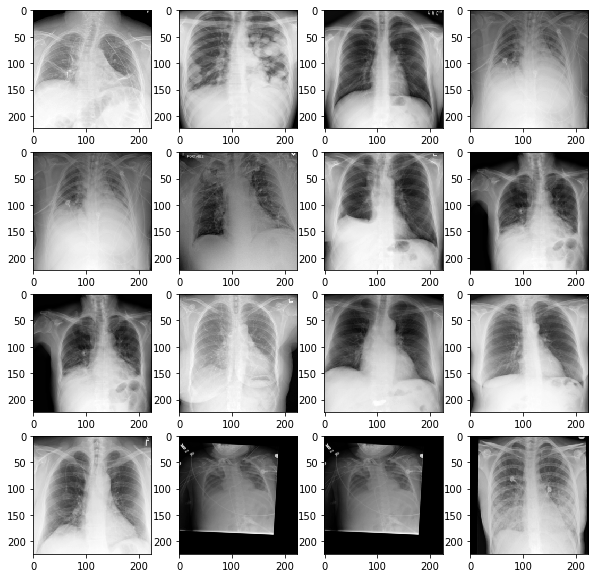

In [8]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = PneumoniaDataset(csv_file=train_labels, root_dir='train_images/', transform=transform)

rows = 4
cols = 4
fig = plt.figure(figsize=(10, 10))

for i in range(1, rows * cols + 1):
    fig.add_subplot(rows, cols, i)
    
    # each image is a 1x244x244 tensor, so we convert to NumPy arrays and get size 244x244
    plt.imshow(dataset[i]['image'].numpy()[0], cmap=plt.cm.gist_gray)
plt.show()

### Step 4: Data-loader initialization

In [94]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

np.random.seed(42)
batch_size = 64
val_split = .1
data_sz = len(dataset)

# splitting the data into training and validation sets
indices = list(range(data_sz))
split = int(np.floor(val_split * data_sz))
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

mini_train_indices = indices[split:split+1024] # for testing training
mini_val_indices = indices[:512] # for testing training

# random batch samplers
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

mini_train_sampler = SubsetRandomSampler(mini_train_indices)
mini_val_sampler = SubsetRandomSampler(mini_val_indices)

# to handle missing images
def rm_na(batch): 
    batch = list(filter(lambda x : x is not None, batch))
    data = [item['image'] for item in batch]
    
    if len(data) > 0:
        data = torch.stack(data)
        target = torch.Tensor([item['label'] for item in batch]).long()
        return [data, target]
    
    return None

# batch feeders
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, collate_fn=rm_na)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=val_sampler, collate_fn=rm_na)

# batch feeders from dataset subset
mini_train_loader = torch.utils.data.DataLoader(
    dataset,batch_size=batch_size, sampler=mini_train_sampler, collate_fn=rm_na)
mini_val_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=mini_val_sampler, collate_fn=rm_na)


# CORRECT LATER
dataloaders = {'train': train_loader, 'val': val_loader,
               'mini_train': mini_train_loader, 'mini_val': mini_val_loader}
dataset_sizes = {'train': len(train_indices), 'val': len(val_indices),
                 'mini_train': len(mini_train_indices), 'mini_val': len(mini_val_indices)}

## Part 3: Transfer Learning from ResNet

### Step 1: Download pre-trained weights

In [181]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

model = models.resnet18(pretrained=True)

### Step 2: How to train the model

In [182]:
import time
from sys import stdout
import copy
from sklearn.metrics import classification_report, roc_auc_score

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
target_names = ['normal', 'abnormal']

def train_model(model, criterion, optimizer, scheduler, num_epochs=25, test_mode=False):
    train_type = 'train' if not test_mode else 'mini_train'
    val_type = 'val' if not test_mode else 'mini_val'
    
    since = time.time()
    acc_history = {
        train_type: [],
        val_type: []
    }
    auc_roc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in [train_type, val_type]:
            if phase == train_type:
                # scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
                preds_concat = torch.Tensor().long().cuda()
                labels_concat = torch.Tensor().long().cuda()

            running_loss = 0.0
            running_corrects = 0
            
            # storing predictions for evaluation metrics
            
            
            running_tp = 0
            running_fp = 0
            running_tn = 0
            running_fn = 0

            # Iterate over data.
            for batch_idx, (inputs, labels) in enumerate(dataloaders[phase]):
                print("Feeding {0} out of {1} imgs".format(
                    (batch_idx + 1) * batch_size,
                    dataset_sizes[phase]), end='\r')

                inputs = inputs.to(device)
                labels = labels.to(device)

                # reset parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == train_type):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == train_type:
                        loss.backward()
                        optimizer.step()

                # accumulate loss
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                # store pred vs. actual
                if phase == val_type:
                    preds_concat = torch.cat([preds_concat, preds])
                    labels_concat = torch.cat([labels_concat, labels.data])
                
#                 # tp, fp, tn, fn
#                 running_tp += sum(preds == labels.data == 1)
#                 running_fp += sum(preds == 1 and labels.data == 0)
#                 running_tn += sum(preds == labels.data == 0)
#                 running_fn += sum(preds == 0 and labels.data == 1)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            acc_history[phase].append([epoch, epoch_loss, epoch_acc])
            
            stdout.flush() # before printing
            print('{} loss: {:.4f} accuracy: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == val_type:
                print(classification_report(labels_concat.cpu(), preds_concat.cpu(), target_names=target_names))
                auc_roc_history.append(roc_auc_score(labels_concat.cpu(), preds_concat.cpu()))
                
            # deep copy the model
            if phase == val_type and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print() # next line

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best validation accuracy: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, acc_history, auc_roc_history

### Step 3: Define hyperparameters

In [183]:
learning_rate = 8e-3
lr_decay_step = 5
decay_factor = 1 # don't decay

num_epochs = 10

dropout = 0.5
weight_init = 'xavier'

### Step 4: Prepare model for transfer learning and train

In [184]:
from torch.optim import lr_scheduler

for param in model.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

# Enabling gradient flow on convolution layer 4
for param in model.layer4.parameters():
    param.requires_grad = True

# if weight_init == 'xavier':
#     torch.nn.init.xavier_uniform(model.fc.parameters())

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer = optim.Adam([
    {'params': model.fc.parameters()},
    {'params': model.layer4.parameters()}
], lr=learning_rate)

# Decay LR
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=lr_decay_step, gamma=decay_factor)

In [185]:
model.to(device)
torch.cuda.get_device_name(0) # GPU check

'Tesla K80'

In [186]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

### Step 5: Training time!

In [187]:
model_trained, acc_hist, auc_hist = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=30, test_mode=False)

Epoch 0/29
----------
train loss: 0.4393 accuracy: 0.8067
val loss: 0.4775 accuracy: 0.8329
             precision    recall  f1-score   support

     normal       0.86      0.91      0.88      2100
   abnormal       0.77      0.65      0.70       922

avg / total       0.83      0.83      0.83      3022


Epoch 1/29
----------
train loss: 0.3856 accuracy: 0.8278
val loss: 0.3732 accuracy: 0.8365
             precision    recall  f1-score   support

     normal       0.88      0.89      0.88      2100
   abnormal       0.74      0.72      0.73       922

avg / total       0.84      0.84      0.84      3022


Epoch 2/29
----------
train loss: 0.3506 accuracy: 0.8417
val loss: 0.3739 accuracy: 0.8319
             precision    recall  f1-score   support

     normal       0.86      0.91      0.88      2100
   abnormal       0.76      0.65      0.70       922

avg / total       0.83      0.83      0.83      3022


Epoch 3/29
----------
train loss: 0.3119 accuracy: 0.8634
val loss: 0.3760 a

train loss: 0.0048 accuracy: 0.9991
val loss: 1.0386 accuracy: 0.8696
             precision    recall  f1-score   support

     normal       0.91      0.90      0.91      2100
   abnormal       0.78      0.79      0.79       922

avg / total       0.87      0.87      0.87      3022


Epoch 28/29
----------
train loss: 0.0180 accuracy: 0.9938
val loss: 0.9292 accuracy: 0.8676
             precision    recall  f1-score   support

     normal       0.90      0.91      0.90      2100
   abnormal       0.78      0.78      0.78       922

avg / total       0.87      0.87      0.87      3022


Epoch 29/29
----------
train loss: 0.0108 accuracy: 0.9965
val loss: 0.9224 accuracy: 0.8534
             precision    recall  f1-score   support

     normal       0.90      0.89      0.89      2100
   abnormal       0.75      0.77      0.76       922

avg / total       0.85      0.85      0.85      3022


Training complete in 337m 22s
Best validation accuracy: 0.876572


### Step 6: Build error graphs

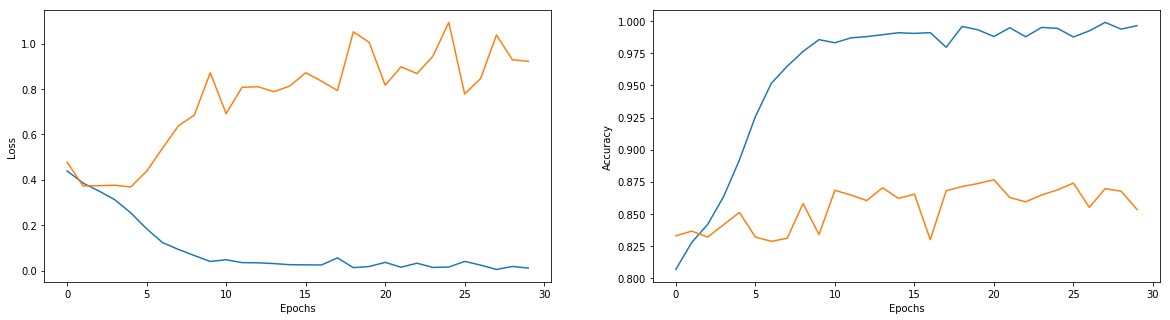

In [189]:
from matplotlib import pyplot as plt
%matplotlib inline 

test_mode = False

def train_val_acc_plot(acc_hist):
    epochs = []
    train_accs = []
    train_losses = []
    val_accs = []
    val_losses = []
    
    train_type = 'train' if not test_mode else 'mini_train'
    val_type = 'val' if not test_mode else 'mini_val'
    
    # fill in accuracies and errors
    for phase in [train_type, val_type]:
        for elem in acc_hist[phase]:
            if phase == train_type:
                train_losses.append(float(elem[1]))
                train_accs.append(float(elem[2]))
            else:
                val_losses.append(float(elem[1]))
                val_accs.append(float(elem[2]))
    epochs = range(len(val_accs))
    
    plt.figure(figsize=(20,5))
    plt.subplot(1,2,1)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(epochs, train_losses)
    plt.plot(epochs, val_losses)

    plt.subplot(1,2,2)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(epochs, train_accs)
    plt.plot(epochs, val_accs)

train_val_acc_plot(acc_hist)

### Step 7: Randomized search for hyperparameters

In [ ]:
learning_rates = []

### Approach 1: Loading Images from SageMaker

In [ ]:
import pydicom
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

# Image.open('s3://sgmoid/rsna-samples/002cb550-2e31-42f1-a29d-fbc279977e71.dcm')

d = pydicom.read_file('rsna-samples/0111d61a-8a5d-4dc8-8c00-7365f8a8de3d.dcm')
im = d.pixel_array
# --- Convert from single-channel grayscale to 3-channel RGB
im = np.stack([im] * 3, axis=2)
plt.imshow(im, cmap=plt.cm.gist_gray)
plt.axis('off')

In [65]:
!pip install --upgrade pip

Requirement already up-to-date: pip in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (19.0.2)


In [66]:
import os

os.listdir("s3://sgmoid/")

FileNotFoundError: [Errno 2] No such file or directory: 's3://sgmoid/'

In [4]:
!pip install pydicom

    100% |████████████████████████████████| 7.0MB 7.7MB/s eta 0:00:01
You are using pip version 10.0.1, however version 19.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
